# Respondent-driven sampling 

Hidden or hard-to-reach populations occur when sampling procedures are nonexistent, and public knowledge about the members is imprecise because of social stigma and criminalization. It is hard to estimate probabilities in this scenario by common demographic census given that the target population produces low response rates. Sex workers, homeless people, men who have sex with men, and drug users are examples. Respondent-driven sampling is a procedure with a dual system of structured incentives in a chain-referral way. Starting with some individuals (seeds) of the target population, each actor recruits others in their network through coupons. Other methods include *Snowball Sampling*, *Key Important Sampling*,  and *Target Sampling*. 

In this notebook, we explore the features of this procedure through a dataset
of activist refugees from Syria {cite:t}`khoury2020data`. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import networkx as nx
import seaborn as sns
sns.set()

## Data

Here we present the data and explain each title 

`id`: sequential case number. 

`recruit.id`: number that identifies each individual, and it is used to link
each participants to one another. The seeds have 1 digit and each new wave
have a digit more. The individual 1 receives the coupons: 11, 12 and 13, the
individual 22 receives 221, 222, 223, and so on. 

`coupon.1, .2, .3`: the coupon received by the individual. 

`degree`: network's degree informed. 

The other columns are answers to demographic and activism questions developed by the research.

In [3]:
data = pd.read_excel("../data/Harvard_refugees_activists/rds_replication_data.xlsx", 
                     dtype = {"id": str,
                              "recruit.id": str, 
                              "coupon.1": str, 
                              "coupon.2": str, 
                              "coupon.3": str})
data.head()

,id,recruit.id,coupon.1,coupon.2,coupon.3,degree,sex,age,education,humanitarian,...,parties,most_recent,employ_status,time_status,formality,cooperation,cooperation_location,syria_pre2011,syria_post2011,trust
0,1,1,11,12,13,30,2,28,6,1,...,3.0,4,1,1,2,1,1.0,1,2,2
1,2,2,21,22,23,6,1,30,7,1,...,3.0,1,1,2,2,1,3.0,2,2,2
2,3,4,41,42,43,25,1,28,4,2,...,3.0,4,2,1,2,1,3.0,2,1,1
3,4,12,121,122,123,3,1,33,6,1,...,2.0,8,2,2,2,1,1.0,2,1,1
4,5,5,51,52,53,30,1,31,6,1,...,3.0,4,2,1,2,1,3.0,1,1,2


Note that commonly required information in RDS is the degree informed by the
recruited individual. The degree reflects different interpretations depending
on the studied population, but, in general terms, it is the number of people
within the population of interest that the individual knows and who know them.
The researches select individuals conveniently to start the sampling, called
*seeds*. After that, they are responsible to recruit the next wave of
participants, and they receive a amount of money for each successful
recruitment (besides of receiving for participating).  This process continues
until a stopping criteria is reached, such as the number of waves, or the
number of participants being a fixed number. Some articles try to answer when
the convergence is achieved. 

Renaming some columns.

In [4]:
data.rename(columns = {"recruit.id": "recruit_id", 
                       "coupon.1": "coupon_1", 
                       "coupon.2": "coupon_2", 
                       "coupon.3": "coupon_3"}, 
                  inplace=True)

Some strings in coupons columns have a space after the number and I strip
them. 

In [5]:
data.recruit_id = data.recruit_id.apply(lambda x: x.strip())
data.coupon_1 = data.coupon_1.apply(lambda x: x.strip())
data.coupon_2 = data.coupon_2.apply(lambda x: x.strip())
data.coupon_3 = data.coupon_3.apply(lambda x: x.strip())

Given that the dataset has big integers, I will change its enumeration rule. Each recruiter will be enumerated acording to its sequencial appearence.

In [6]:
# rename recruiter with sequencial appearance
rename_dict = dict(zip(data.recruit_id, data.id))
# obtain the wave of the recruiter
wave_dict = dict(zip(data.recruit_id, data.recruit_id.apply(lambda x: len(str(x)))))

In [7]:
data.coupon_1 = data.coupon_1.map(rename_dict)
data.coupon_2 = data.coupon_2.map(rename_dict)
data.coupon_3 = data.coupon_3.map(rename_dict)
data.recruit_id = data.recruit_id.map(wave_dict)
data.rename(columns = {"recruit_id": "wave"}, inplace = True)

## Network construction 

Here we see the network and the demographic variables associated with each
node. These questions change from study to study. Diagnostic tests are also
common. 

In [8]:
nodes = [(s[1][0], {"wave": s[1].loc["wave"], 
                    "degree": s[1].loc["degree"], 
                    "sex": s[1].loc["sex"], 
                    "age": s[1].loc["age"],
                    "employ": s[1].loc["employ_status"],
                    "advocacy": s[1].loc["advocacy"],
                    "education": s[1].loc["education"]}) for s in data.iterrows()]

edges = [(s[1][0], s[1][2]) for s in data.iterrows() if pd.notna(s[1][2])]
edges.extend([(s[1][0], s[1][3]) for s in data.iterrows() if pd.notna(s[1][3])])
edges.extend([(s[1][0], s[1][4]) for s in data.iterrows() if pd.notna(s[1][4])])

In [9]:
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

Coloring according a possible question. 

In [10]:
g = 'advocacy'
groups = set(nx.get_node_attributes(G,g).values())
mapping = dict(zip(sorted(groups),range(len(groups))))
nodes = G.nodes()
colors = [mapping[G.nodes[n][g]] for n in nodes]
color_map = {0: "#1D7874", 1: "#ee2e31", 2: "#f4c095"}
colors = [color_map[i] for i in colors]

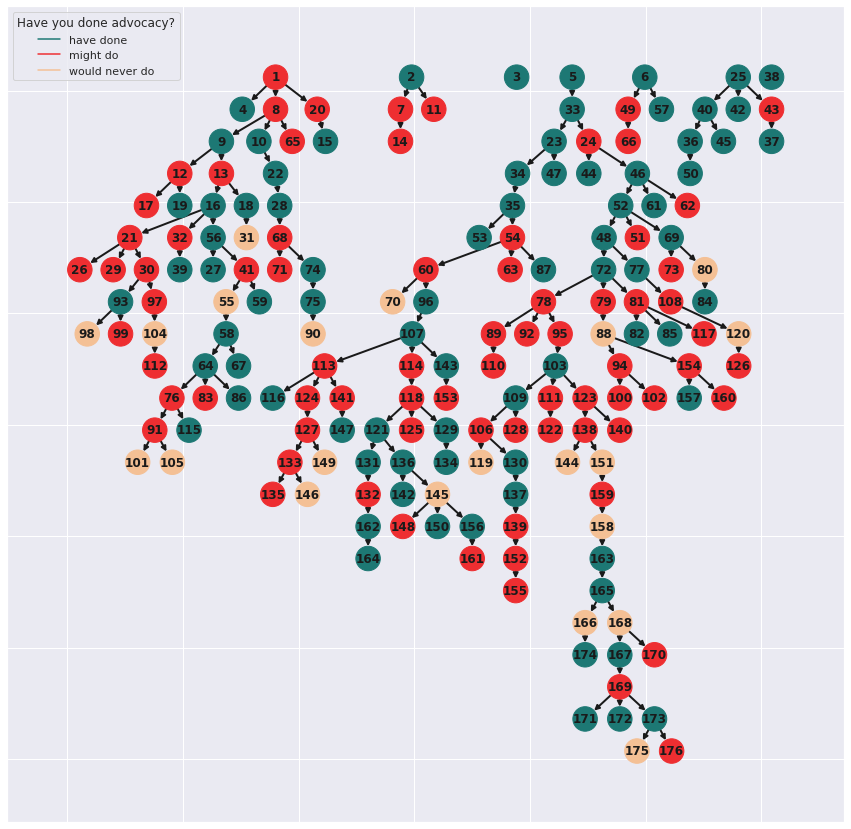

In [11]:
options = {
    'node_color': colors,
    'node_size': 600,
    'width': 2,
    'with_labels': True,
    'font_weight': 'bold'
}

plt.figure(figsize = (15,15))
pos = graphviz_layout(G, prog="dot")

for label in groups:
    plt.plot([0],[0],
             color=color_map[mapping[label]],
             label={1: 'have done', 2:'might do', 3:'would never do'}[label])

nx.draw_networkx(G, pos, **options)


plt.legend(loc="upper left", title = "Have you done advocacy?")
plt.savefig("../images/graph-rds-advocacy-harvard.png", bbox_inches = 'tight')
plt.show()

Each participant receives a fixed number of coupons (generally three, as we see in this study). This coupon has information about the research site and an identification number. The recruiter and the recruited receive theirs rewarding. Notice that several branches ended very early, such ad the seeds 2 and 3 branches. It shows the importance of having several seeds. 

## Information about the network 

Below we observe some information about the network. Note that the out degree
mean is less than 1. 

In [12]:
sum(dict(G.out_degree()).values())/len(dict(G.out_degree()).values())

0.9602272727272727

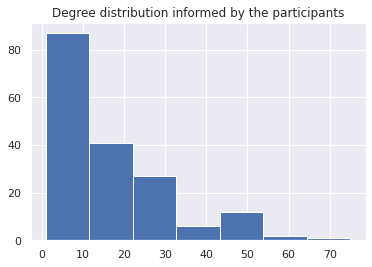

In [13]:
data.degree.hist(bins=7)
plt.title("Degree distribution informed by the participants")
plt.show()

## Estimating transition probabilities 

In {cite:t}`heckathorn1997`, RDS was modeled as a Markov chain in which the
states were possible answers to the questions. For instance: Sex, Profession,
Ethnicity, among others. Then, the recruiter in a state has specific
probabilities of recruiting an individual from the same ot another state.
These probabilities can be inferred from the data. Here we use a frequentist
approach suggested in the work of Heckathorn. Nowadays, this model has
improved.

In [14]:
recruitments = {i: dict(zip(groups, [0,0,0])) for i in groups}

for node in G.nodes():
    employ_recruiter = G.nodes[node]["advocacy"]
    for neighbor in G.neighbors(node): 
        recruitments[employ_recruiter][G.nodes[neighbor]["advocacy"]] += 1
        
for recruiter in recruitments.keys():
    recruiteds = sum(recruitments[recruiter].values())
    for recruit in recruitments[recruiter].keys(): 
        recruitments[recruiter][recruit] /= recruiteds

In [15]:
recruitments

{1: {1: 0.46153846153846156, 2: 0.4358974358974359, 3: 0.10256410256410256},
 2: {1: 0.38961038961038963, 2: 0.44155844155844154, 3: 0.16883116883116883},
 3: {1: 0.5, 2: 0.5, 3: 0.0}}

In [16]:
waves = list(range(data.wave.max()))
a = np.zeros((len(waves), 3))

for wave in waves: 
    for i in [1,2,3]:
        try: 
            value = data[data.wave == wave+1].advocacy.value_counts()[i]
        except: 
            value = 0
        a[wave][i-1] = value
        
a = a/a.sum(axis=1).reshape(-1,1)

Below we are observing the proportion of individuals in different states for
each wave. We would expect a convergence as the Markov Chain theory proves.
However, this indicates that either the Markov is not a good model, or the
waves are not a good representation of the transitions. 

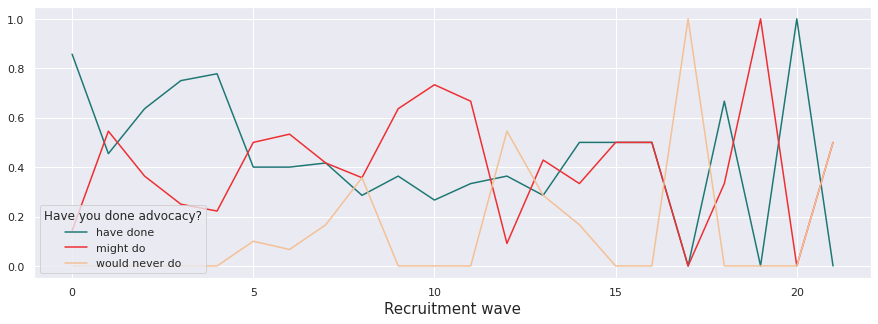

In [17]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(waves, a[:,0], label = 'have done', color = "#1D7874")
ax.plot(waves, a[:,1], label = 'might do', color = "#ee2e31")
ax.plot(waves, a[:,2], label = 'would never do', color = "#f4c095")
ax.legend(loc = 'lower left', title = 'Have you done advocacy?')
ax.set_xlabel("Recruitment wave", fontsize = 15)
plt.savefig("../images/recruitment-wave-convergence.png", bbox_inches='tight')
plt.show()

Using the estimated probabilities for the transition matrix, we can have the
stationary (and convergence) distribution indicating the proportion for each
stet in the long run. 

In [18]:
transition = np.array([[recruitments[i][j] for j in range(1,4)] for i in range(1,4)])

x = np.linalg.eig(transition.T)[1][:,0:1]
x/sum(x)

array([[0.43406007],
       [0.44610459],
       [0.11983534]])